# Estimate transient forcing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../Data_processing/')

from estimation import *
from plotting_functions import *
from processing_functions import *

#import importlib
#import my_functions as f
#importlib.reload(f) # needed to load new changes in my_functions
#import warnings
#warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 0})

#saveforcingdata = True # create one file for each model/member, combine them later if needed
#saveforcingfigure = False
#save_tasdiff = True
saveforcingdata = False; saveforcingfigure = False; save_tasdiff = False


In [2]:
## Find models with abrupt-4xCO2 experiments 
## (necessary condition to make other forcing estimates)
## Currently, only models with this experiment exist in directory

experiments = {}
directory = '../Processed_data/Global_annual_anomalies/'
model_names = [ f.name for f in os.scandir(directory) if f.is_dir() and f.name !='.ipynb_checkpoints']
model_names.sort()
model_names.remove('CIESM')
model_names.remove('CAS-ESM2-0')
model_names.remove('MIROC-ES2H')
#exp = 'abrupt-4xCO2'
#for model in model_names:
#    modeldirectory = os.path.join(directory, model)
#    modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']
#    if exp in modelexp_names:
#        experiments[model] = {}
#        experiments[model][exp] = find_members(model, exp)
#models = experiments.keys()


In [4]:
model_names[17]

'EC-Earth3'

Forcing estimates saved for HadGEM3-GC31-LL ssp585 r1i1p1f3
Forcing estimates saved for HadGEM3-GC31-LL ssp585 r2i1p1f3
Forcing estimates saved for HadGEM3-GC31-LL ssp585 r3i1p1f3
Forcing estimates saved for HadGEM3-GC31-LL ssp585 r4i1p1f3


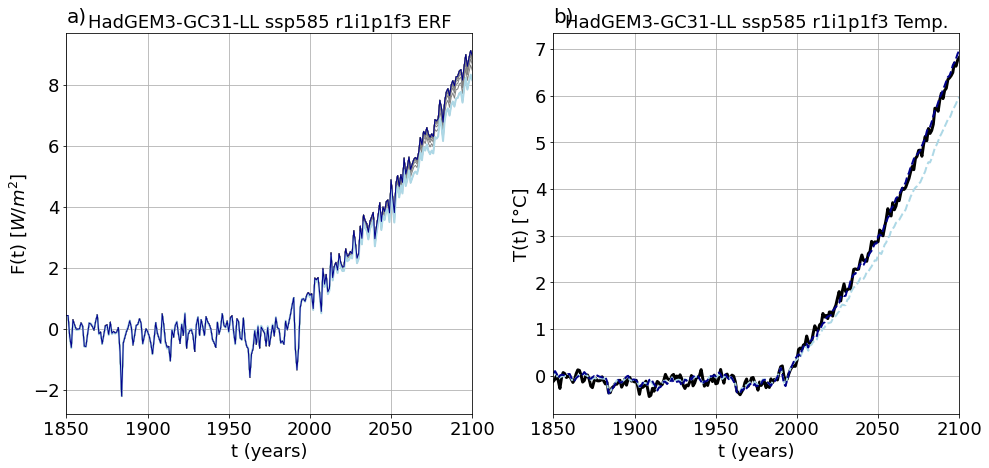

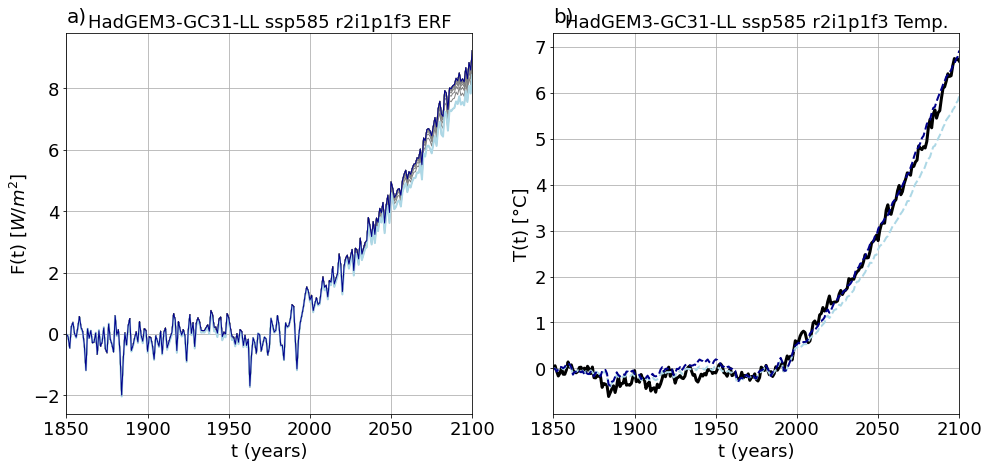

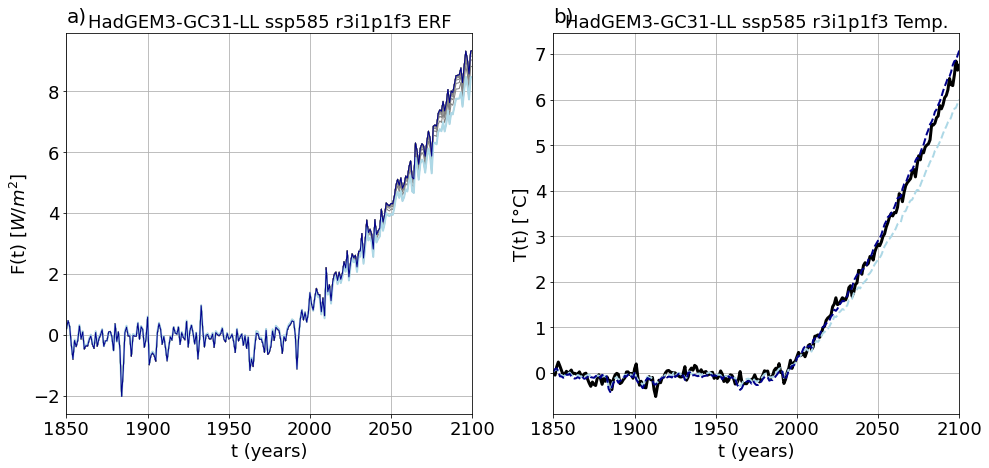

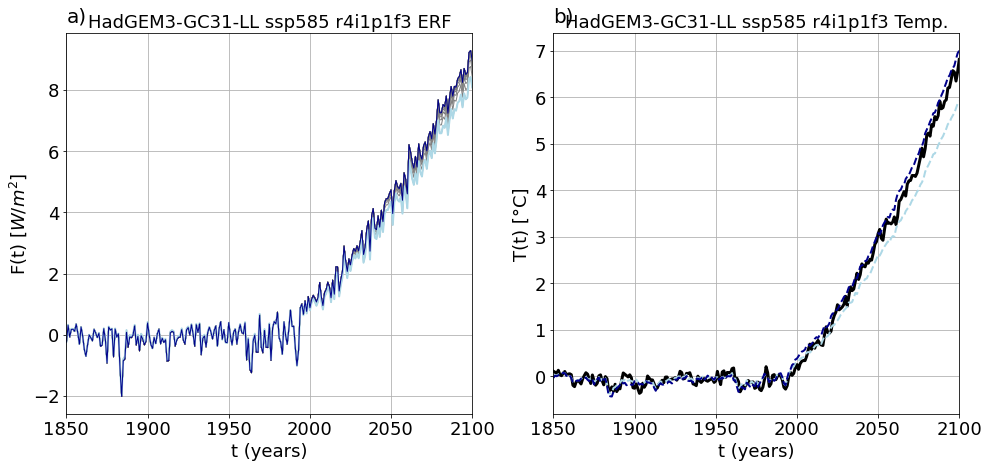

In [14]:
units = [' [K]', ' [W/$m^2$]', ' [W/$m^2$]', ' [W/$m^2$]']

# choose experiment:
#exp = '1pctCO2'
exp = 'historical'
#exp = 'hist-GHG'
#exp = 'ssp585'

#exp = 'hist-other'

#for model in model_names[0:2]:
for model in ['HadGEM3-GC31-LL']:
#for model in ['IPSL-CM6A-LR']:
#for model in ['GFDL-CM4']:
    #if model not in ['EC-Earth3']:
    modeldirectory = os.path.join(directory, model)
    modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in modelexp_names:
        members = find_members(model, exp)
    else:
        continue

    branch_time_file = '../Processed_data/Branch_times/' + model + '_branch_times.csv'
    table = pd.read_table(branch_time_file,index_col=0, sep = ',')
    pd.set_option('display.max_rows', None)
    branch_info_corrections(table, printing = False);
    exptable = table.loc[table['exp'] == exp]

    for member in members:
    #for member in ['r1i1p1f2']:
        member_df = exptable.loc[exptable['member'] == member]

        data = load_anom(model, exp, member)
        if data.empty:
            print('Empty dataframe for', model, exp, member)
            continue

        # if ssp experiment, then we need to include the response
        # generated by historical forcing
        # (for other experiments that branch from piControl,
        # previous forcing, and hence the temperature response
        # to previous forcing is supposed to be 0)
        if exp[:3] == 'ssp':
            # load historical data also and concatenate
            historical_members = find_members(model, 'historical')
            parent_member = member_df['parent_variant_id'].values[0]
            if parent_member in historical_members:
                historical_data = load_anom(model, 'historical', parent_member)
                data = pd.concat([historical_data, data])
            else:
                print('Corresponding historical member does not exist for', model, exp, member)
                continue
        if model == 'EC-Earth3': # data should start in 1970 after the previous if-test
            r_value = int(member.split("r")[1].split("i")[0])
            if r_value > 100: # happens only for historical and ssp experiments
                # then historical exp starts in 1970, and we need to know the temperature response from its EC-Earth3-Veg parent
                lens_parent_member = find_ECEarth3lens_parent(member)
                historical_parent_data = load_anom('EC-Earth3-Veg', 'historical', lens_parent_member)
                historical_parent_data = historical_parent_data[historical_parent_data.index < 1970]
                data = pd.concat([historical_parent_data, data])

        years = data.index
        #years = np.arange(0, len(data));
        N = data['rsdt'] - data['rsut'] - data['rlut']
        if model == 'AWI-CM-1-1-MR':
            if exp[:3] == 'ssp' or exp == 'historical':
                data['tas'][1850]=0 # set an approximate value since it does not exist for some reason...
        #variables = list(data)

        #plot_allvar_preloaded(years, data, model, member, plot_title = model + ' ' + exp + ' ' + member)
        #plot_tasandN(years, data['tas'], N, plot_title = model + ' ' + exp + ' ' + member)

        F = forcing_F13(data['tas'], N, model)

        # load parameters needed to make new forcing estimate:
        filename = 'best_estimated_parameters2_allmembers4xCO2.csv'
        #filename = 'best_estimated_parameters_calto1pctCO2_allmembers.csv'
        
        parameter_table = pd.read_csv('../Estimates/' + filename, index_col=0)
        taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
        a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
        b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
        F2x = parameter_table.loc[model,'F2x']
        T2x = parameter_table.loc[model,'T2x']

        dim = len(taulist)
        if any(a_n == 0):
            dim = np.count_nonzero(a_n[:dim])
            zeroindex = np.where(a_n == 0)[0]
            a_n = np.delete(a_n,zeroindex)
            b_n = np.delete(b_n,zeroindex)
            taulist = np.delete(taulist,zeroindex)
        fbparlist = (b_n/a_n)[:dim]
        amplitudes = a_n[:dim]/(2*F2x*taulist)

        t = np.arange(0,len(F))
        #tas_pred = tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = F)
        #Tn = amplitudes*tas_pred

        # Compute new estimate of forcing
        it = 20  # number of iterations
        Fiarray = np.full((len(F),it),np.nan)
        Tiarray = np.full((len(F),it),np.nan)

        Fi = F
        for i in range(0,it):
            tas_pred = tas_predictors(t, taulist, exptype = 'timevaryingforcing',\
                                        timevaryingforcing = Fi)
            Tni = amplitudes*tas_pred
            Fi = N + Tni@fbparlist
            Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)

        #plot_components(years, Tn, taulist)

        forcing_response_figure(years, Fiarray, Tiarray, Tcoupled = data['tas'], titlestr = model + ' ' + exp + ' ' + member)

        if saveforcingfigure == True:
            plt.savefig('../Figures/Transient_forcing_response/' + model + '_' + exp + '_' + member + '_forcing_and_response.pdf', format='pdf', dpi=600, bbox_inches="tight")
        #plt.close()

        if saveforcingdata == True:
            # create model directory if it does not already exist
            modelexpdir = os.path.join('../Estimates/Transient_forcing_estimates/', model, exp)
            if os.path.isdir(modelexpdir) == False:
                os.makedirs(modelexpdir)
            index = pd.Index(years, name='Year')

            # save files
            if exp[:3] == 'ssp':
                expstr = 'historicaland' + exp
            else:
                expstr = exp
            df_F13 = pd.DataFrame(F.values, index=index, columns=['ERF'])
            modelfilename = model + '_' + expstr + '_' + member + '_F13_ERF.csv'
            df_F13.to_csv(modelexpdir + '/' + modelfilename)

            df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])
            modelfilename = model + '_' + expstr + '_' + member + '_ERF.csv'
            df_F.to_csv(modelexpdir + '/' + modelfilename)
            print('Forcing estimates saved for', model, exp, member)

        if save_tasdiff == True:
            # save difference between linear response to new forcing and coupled model tas
            tas_diff = Tiarray[:,-1] - data['tas']
            index = pd.Index(years, name='Year')
            df_tas = pd.DataFrame(tas_diff.values, index=index, columns=['tas_diff'])
            tas_filename = model + '_' + expstr + '_' + member + '_tas_diff.csv'
            df_tas.to_csv(modelexpdir + '/' + tas_filename)




KeyboardInterrupt: 

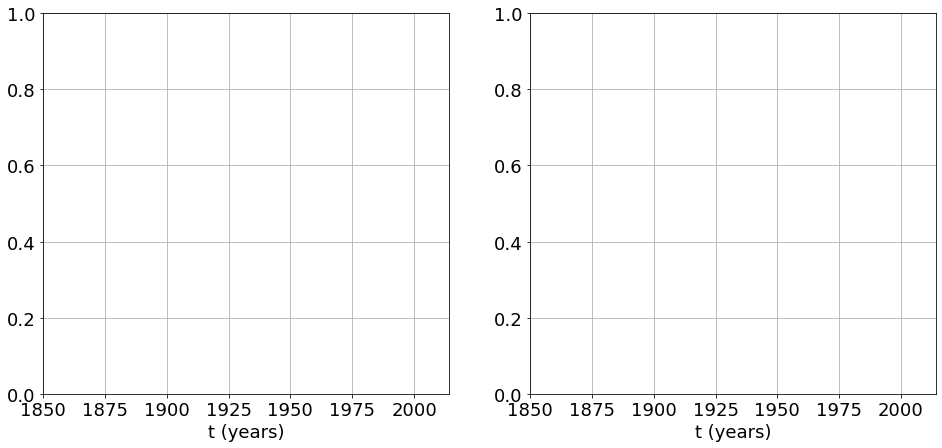

In [11]:
units = [' [K]', ' [W/$m^2$]', ' [W/$m^2$]', ' [W/$m^2$]']

# choose experiment:
#exp = '1pctCO2'
exp = 'historical'
#exp = 'hist-nat'
#exp = 'ssp585'

#exp = 'hist-other'

#for model in model_names[0:2]:
#for model in ['EC-Earth3']:
for model in ['GFDL-ESM4']:
    #if model not in ['EC-Earth3']:
    modeldirectory = os.path.join(directory, model)
    modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in modelexp_names:
        members = find_members(model, exp)
    else:
        continue

    branch_time_file = '../Processed_data/Branch_times/' + model + '_branch_times.csv'
    table = pd.read_table(branch_time_file,index_col=0, sep = ',')
    pd.set_option('display.max_rows', None)
    branch_info_corrections(table, printing = False);
    exptable = table.loc[table['exp'] == exp]

    for member in members:
    #for member in ['r1i1p1f2']:
        member_df = exptable.loc[exptable['member'] == member]

        data = load_anom(model, exp, member)
        if data.empty:
            print('Empty dataframe for', model, exp, member)
            continue

        # if ssp experiment, then we need to include the response
        # generated by historical forcing
        # (for other experiments that branch from piControl,
        # previous forcing, and hence the temperature response
        # to previous forcing is supposed to be 0)
        if exp[:3] == 'ssp':
            # load historical data also and concatenate
            historical_members = find_members(model, 'historical')
            parent_member = member_df['parent_variant_id'].values[0]
            if parent_member in historical_members:
                historical_data = load_anom(model, 'historical', parent_member)
                data = pd.concat([historical_data, data])
            else:
                print('Corresponding historical member does not exist for', model, exp, member)
                continue
        if model == 'EC-Earth3': # data should start in 1970 after the previous if-test
            r_value = int(member.split("r")[1].split("i")[0])
            if r_value > 100: # happens only for historical and ssp experiments
                # then historical exp starts in 1970, and we need to know the temperature response from its EC-Earth3-Veg parent
                lens_parent_member = find_ECEarth3lens_parent(member)
                historical_parent_data = load_anom('EC-Earth3-Veg', 'historical', lens_parent_member)
                historical_parent_data = historical_parent_data[historical_parent_data.index < 1970]
                data = pd.concat([historical_parent_data, data])

        years = data.index
        #years = np.arange(0, len(data));
        N = data['rsdt'] - data['rsut'] - data['rlut']
        if model == 'AWI-CM-1-1-MR':
            if exp[:3] == 'ssp' or exp == 'historical':
                data['tas'][1850]=0 # set an approximate value since it does not exist for some reason...
        #variables = list(data)

        #plot_allvar_preloaded(years, data, model, member, plot_title = model + ' ' + exp + ' ' + member)
        #plot_tasandN(years, data['tas'], N, plot_title = model + ' ' + exp + ' ' + member)

        F = forcing_F13(data['tas'], N, model)

        # load parameters needed to make new forcing estimate:
        filename = 'best_estimated_parameters_allmembers.csv'
        #filename = 'best_estimated_parameters_calto1pctCO2_allmembers.csv'
        
        parameter_table = pd.read_csv('../Estimates/' + filename, index_col=0)
        taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
        a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
        b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
        F2x = parameter_table.loc[model,'F2x']
        T2x = parameter_table.loc[model,'T2x']

        dim = len(taulist)
        if any(a_n == 0):
            dim = np.count_nonzero(a_n[:dim])
            zeroindex = np.where(a_n == 0)[0]
            a_n = np.delete(a_n,zeroindex)
            b_n = np.delete(b_n,zeroindex)
            taulist = np.delete(taulist,zeroindex)
        fbparlist = (b_n/a_n)[:dim]
        amplitudes = a_n[:dim]/(2*F2x*taulist)

        t = np.arange(0,len(F))
        #tas_pred = tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = F)
        #Tn = amplitudes*tas_pred

        # Compute new estimate of forcing
        it = 20  # number of iterations
        Fiarray = np.full((len(F),it),np.nan)
        Tiarray = np.full((len(F),it),np.nan)

        Fi = F
        for i in range(0,it):
            tas_pred = tas_predictors(t, taulist, exptype = 'timevaryingforcing',\
                                        timevaryingforcing = Fi)
            Tni = amplitudes*tas_pred
            Fi = N + Tni@fbparlist
            Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)

        #plot_components(years, Tn, taulist)

        forcing_response_figure(years, Fiarray, Tiarray, Tcoupled = data['tas'], titlestr = model + ' ' + exp + ' ' + member)

        if saveforcingfigure == True:
            plt.savefig('../Figures/Transient_forcing_response/' + model + '_' + exp + '_' + member + '_forcing_and_response.pdf', format='pdf', dpi=600, bbox_inches="tight")
        #plt.close()

        if saveforcingdata == True:
            # create model directory if it does not already exist
            modelexpdir = os.path.join('../Estimates/Transient_forcing_estimates/', model, exp)
            if os.path.isdir(modelexpdir) == False:
                os.makedirs(modelexpdir)
            index = pd.Index(years, name='Year')

            # save files
            if exp[:3] == 'ssp':
                expstr = 'historicaland' + exp
            else:
                expstr = exp
            df_F13 = pd.DataFrame(F.values, index=index, columns=['ERF'])
            modelfilename = model + '_' + expstr + '_' + member + '_F13_ERF.csv'
            df_F13.to_csv(modelexpdir + '/' + modelfilename)

            df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])
            modelfilename = model + '_' + expstr + '_' + member + '_ERF.csv'
            df_F.to_csv(modelexpdir + '/' + modelfilename)
            print('Forcing estimates saved for', model, exp, member)

        if save_tasdiff == True:
            # save difference between linear response to new forcing and coupled model tas
            tas_diff = Tiarray[:,-1] - data['tas']
            index = pd.Index(years, name='Year')
            df_tas = pd.DataFrame(tas_diff.values, index=index, columns=['tas_diff'])
            tas_filename = model + '_' + expstr + '_' + member + '_tas_diff.csv'
            df_tas.to_csv(modelexpdir + '/' + tas_filename)




In [4]:
data

,tas,rlut,rsut,rsdt
year,,,,
1850,-0.273721,-0.312685,0.047496,0.022538
1851,-0.097008,-0.070641,-0.336506,0.011662
1852,0.023894,0.117904,-0.096536,0.042040
1853,-0.108460,-0.082200,-0.053255,-0.009620
1854,-0.205674,-0.251404,0.265313,-0.036802
1855,-0.087709,-0.171211,-0.634115,-0.053673
1856,-0.001801,-0.029433,-0.383869,-0.026580
1857,0.052697,0.001500,-0.027923,-0.046491
1858,0.013405,-0.035331,-0.030110,-0.013254
